In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use ('dark_background')

import matplotlib as mlp

mlp.rcParams['lines.linewidth'] = 2

mlp.rcParams['xtick.major.size'] = 12
mlp.rcParams['xtick.major.width'] = 2
mlp.rcParams['xtick.labelsize'] = 10
mlp.rcParams['xtick.color'] = '#FF5533'

mlp.rcParams['ytick.major.size'] = 12
mlp.rcParams['ytick.major.width'] = 2
mlp.rcParams['ytick.labelsize'] = 10
mlp.rcParams['ytick.color'] = '#FF5533'

mlp.rcParams['axes.labelsize'] = 10
mlp.rcParams['axes.titlesize'] = 16
mlp.rcParams['axes.titlecolor'] = '#00B050'
mlp.rcParams['axes.labelcolor'] = '#00B050'

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../data/processed_train.csv')
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


In [3]:
print(sum(data['HasDetections'] == 1), '- positive class,')
print(sum(data['HasDetections'] == 0), '- negative class')

20012 - positive class,
99940 - negative class


Разобьем выборку на тест и трейн

In [4]:
from sklearn.model_selection import train_test_split

X = data.drop('HasDetections', axis=1)
y = data['HasDetections']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=33)

Обучите LogReg и SVM с помощью классов `LogisticRegression` и `LinearSVC`. Добавьте шаг стандартизации данных в пайплайны. Для разнообразия, возьмем `MinMaxScaler`. Пайплайны запишем в переменные `pipe_lr` и `pipe_svm` соответственно!

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler

### Your code is here

pipe_lr = Pipeline([
    ("scaler_lr", MinMaxScaler()),
    ("LR", LogisticRegression(penalty='l2'))
])

pipe_svm = Pipeline([
    ("scaler_svm", MinMaxScaler()),
    ("SVM", LinearSVC())
])


In [6]:
### Обучаем модели на трейне
### Your code is here

pipe_lr.fit(X_train, y_train)
pipe_svm.fit(X_train, y_train)

Pipeline(steps=[('scaler_svm', MinMaxScaler()), ('SVM', LinearSVC())])

In [7]:
print(f"LR-accuracy: {pipe_lr.score(X_test, y_test):.3f}")
print(f"SVM-accuracy: {pipe_svm.score(X_test, y_test):.3f}")

LR-accuracy: 0.843
SVM-accuracy: 0.840


Постройте ROC для обеих моделей, посчитайте AUC . Конечно же, обучение проводите на трейне, а замеры - на тесте.

Заметьте! Классическая реализация `SVM`, как и в лекциях, не дает никакой оценки вероятности. Чтобы трансформировать выходы в вероятности, на практике мы использовали функцию-сигмоиду. Здесь предлагаем Вам трансформировать выходы `decision_function` в вероятности пропорциональным способом.

Например, вы обучили `SVM`, и на тестовых данных модель выдала следующие выходы `decision_function`:

(-10, -5, 0, +2, +10, +15)

Для каждого числа необходимо сделать преобразование в выражение вида `P(y = +1 | x)`.

С одной стороны, отрицательный знак числа будет сигнализировать нам о том, что `P(y = +1 | x) < 0.5`.

Тогда положительный о том, что `P(y = +1 | x) > 0.5`. 

С другой стороны, для тех объектов, в которых модель уверена больше всего, положим краевые вероятности. Для примера выше:

`P(y = +1 | -10) = 0`, `P(y = +1 | +15) = 1`. Для всех промежуточных объектов применим пропорциональное преобразование. Например:

$$
P(y = +1 | -5) = \frac{|-5-(-10)|}{|-10|} \cdot 0.5
$$

$$
P(y = +1 | +2) = \frac{|+2|}{|+15|} \cdot 0.5 + 0.5
$$
Таким образом мы можем перевести выходы SVM в отрезок [0;1] и попробовать интерпретировать новые числа как вероятности, чтобы изобразить калибровочную кривую. При таком преобразовании пропорции внутри первоначально отрицательных и внутри положительных чисел сохраняются.

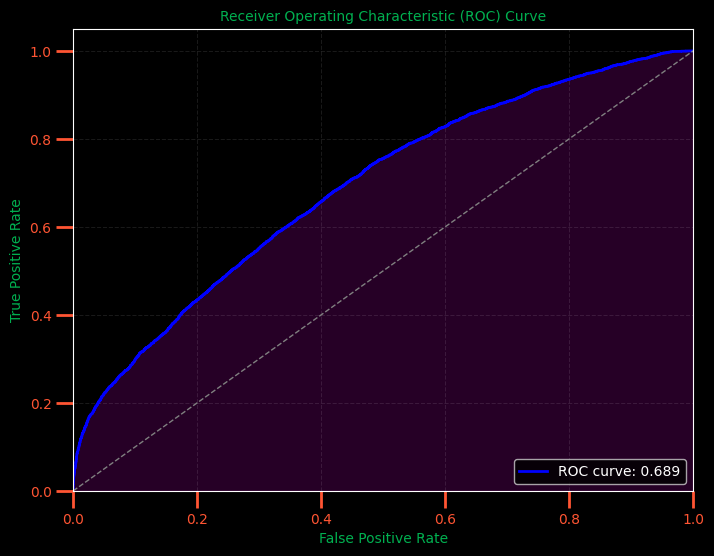

In [8]:
### С изображением рок-кривой для ЛогРега не будет проблем:
### Your code is here

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

# Получение данных ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, pipe_lr.predict_proba(X_test)[:, 1])

# Построение ROC-кривой с настройками внешнего вида
plt.figure(figsize=(8, 6))  # Размер графика
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve: {auc(fpr, tpr):.3f}")  # Цвет, ширина линии и название кривой
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Добавление диагональной пунктирной линии
plt.xlim([0.0, 1.0])  # Пределы оси x
plt.ylim([0.0, 1.05])  # Пределы оси y
plt.xlabel('False Positive Rate')  # Подпись оси x
plt.ylabel('True Positive Rate')  # Подпись оси y
plt.title('Receiver Operating Characteristic (ROC) Curve')  # Название графика
plt.grid(True, alpha=0.1, linestyle="--")  # Включение сетки
plt.legend(loc="lower right")  # Расположение легенды

# Закраска площади под ROC-кривой
plt.fill_between(fpr, tpr, color='purple', alpha=0.3)

# Отображение графика
plt.show()


In [9]:
### А для того, чтобы построить и изобразить рок-кривую для SVM, придется
### в начале преобразовать выходы pipe_svm.decision_function

### Your code is here

from sklearn.preprocessing import MinMaxScaler

# Преобразование decision_function в вероятности с использованием пропорционального преобразования
def decision_function_to_proba(decision_function):
    # Нормализуем значения decision_function в диапазоне от 0 до 1
    scaler = MinMaxScaler()
    scaled_decision_function = scaler.fit_transform(decision_function.reshape(-1, 1))

    # Возвращаем нормализованные значения
    return scaled_decision_function.flatten()


In [10]:
pipe_svm_proba = pd.DataFrame(decision_function_to_proba(pipe_svm.decision_function(X_test)), columns=['probability_svm'])
pipe_lr_proba = pd.DataFrame(pipe_lr.predict_proba(X_test)[:, 1], columns=['probability_lr'])
df = pd.concat([pipe_svm_proba, pipe_lr_proba], axis=1)
df

,probability_svm,probability_lr
0,0.511346,0.216210
1,0.461536,0.159857
2,0.430100,0.111288
3,0.484447,0.277224
4,0.395523,0.096308
...,...,...
23986,0.385836,0.074720
23987,0.393810,0.084576
23988,0.421058,0.105352
23989,0.491519,0.182552


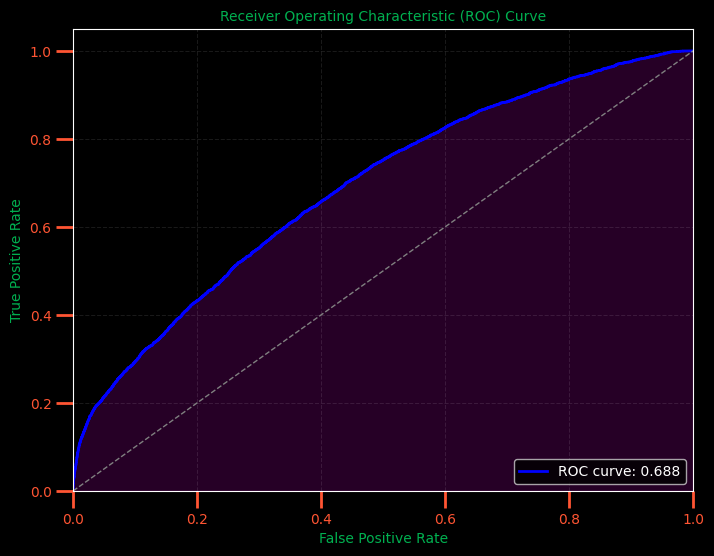

In [11]:
from sklearn.metrics import auc 

### Your code is here

# Получение данных ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, decision_function_to_proba(pipe_svm.decision_function(X_test)))

# Построение ROC-кривой с настройками внешнего вида
plt.figure(figsize=(8, 6))  # Размер графика
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve: {auc(fpr, tpr):.3f}")  # Цвет, ширина линии и название кривой
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Добавление диагональной пунктирной линии
plt.xlim([0.0, 1.0])  # Пределы оси x
plt.ylim([0.0, 1.05])  # Пределы оси y
plt.xlabel('False Positive Rate')  # Подпись оси x
plt.ylabel('True Positive Rate')  # Подпись оси y
plt.title('Receiver Operating Characteristic (ROC) Curve')  # Название графика
plt.grid(True, alpha=0.1, linestyle="--")  # Включение сетки
plt.legend(loc="lower right")  # Расположение легенды

# Закраска площади под ROC-кривой
plt.fill_between(fpr, tpr, color='purple', alpha=0.3)

# Отображение графика
plt.show()


Постройте калибровочные кривые для обеих моделей. Методом from_estimator для svm воспользоваться не получится.

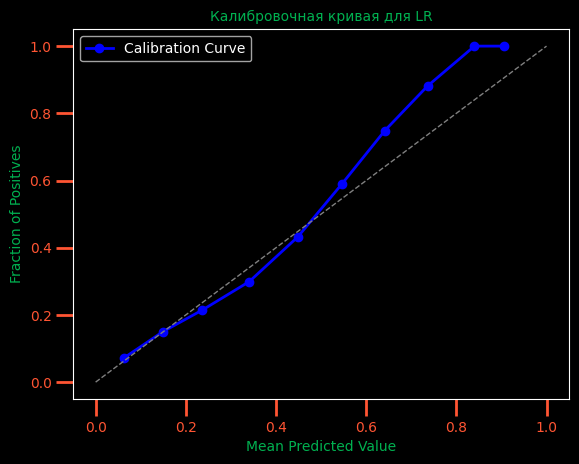

In [12]:
from sklearn.calibration import calibration_curve

prob_pos = pipe_lr.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

fig, ax = plt.subplots()
ax.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Calibration Curve', color='b')
ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Добавление диагональной пунктирной линии
ax.set_title('Калибровочная кривая для LR')
ax.set_xlabel('Mean Predicted Value')
ax.set_ylabel('Fraction of Positives')
ax.legend()
plt.show()

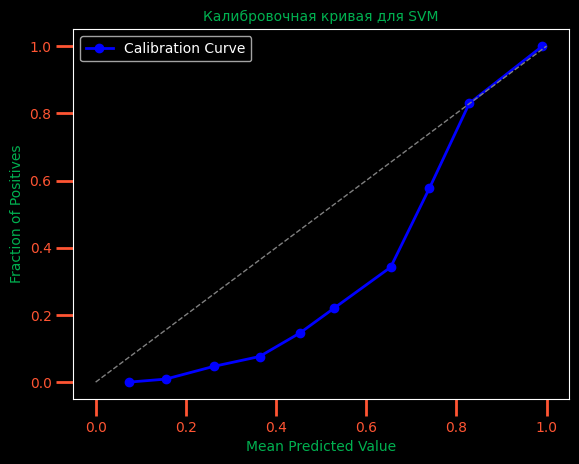

In [13]:
from sklearn.calibration import calibration_curve

prob_pos = decision_function_to_proba(pipe_svm.decision_function(X_test))
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

fig, ax = plt.subplots()
ax.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Calibration Curve', color='b')
ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Добавление диагональной пунктирной линии
ax.set_title('Калибровочная кривая для SVM')
ax.set_xlabel('Mean Predicted Value')
ax.set_ylabel('Fraction of Positives')
ax.legend()
plt.show()

**Какая калибровочная кривая ближе к диагонали?  Откалибруйте SVM способом как в практике и изобразите новую кривую!

In [14]:
### Калибровка

from sklearn.calibration import CalibratedClassifierCV

### Your code is here

calibration = CalibratedClassifierCV(pipe_svm, cv=5, method='sigmoid')
calibration.fit(X_train, y_train)
calibration_probs = calibration.predict_proba(X_test)[:, 1]

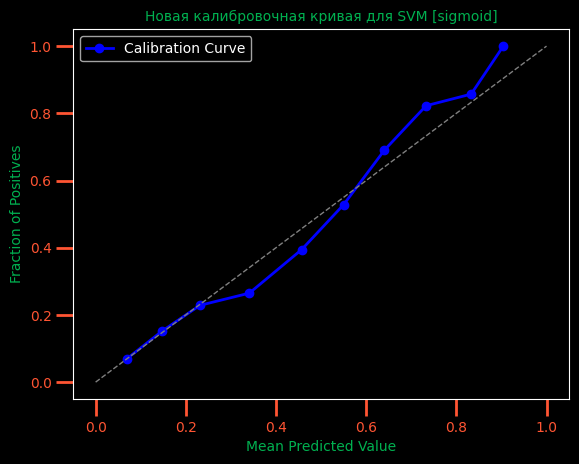

In [16]:
### Новая кривая

### Your code is here

prob_pos = calibration_probs
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

fig, ax = plt.subplots()
ax.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Calibration Curve', color='b')
ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Добавление диагональной пунктирной линии
ax.set_title('Новая калибровочная кривая для SVM [sigmoid]')
ax.set_xlabel('Mean Predicted Value')
ax.set_ylabel('Fraction of Positives')
ax.legend()
plt.show()


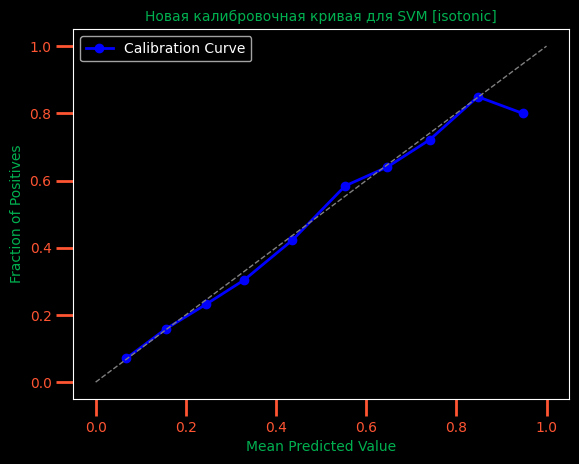

In [17]:
calibration_isotonic = CalibratedClassifierCV(pipe_svm, cv=5, method='isotonic')
calibration_isotonic.fit(X_train, y_train)
calibration_probs = calibration_isotonic.predict_proba(X_test)[:, 1]

prob_pos = calibration_probs
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

fig, ax = plt.subplots()
ax.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Calibration Curve', color='b')
ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Добавление диагональной пунктирной линии
ax.set_title('Новая калибровочная кривая для SVM [isotonic]')
ax.set_xlabel('Mean Predicted Value')
ax.set_ylabel('Fraction of Positives')
ax.legend()
plt.show()